# 태양 이벤트 탐지

## 데이터 불러오기

In [1]:
import json
import os
import shutil

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import pandas as pd
import yaml
from PIL import Image
from tqdm import tqdm

DATASET_ROOT = "/mnt/elice/dataset"  # 데이터 셋의 루트 디렉토리
LABELS_DIR = "labels"
IMAGE_DIR = "images"
TRAIN_DIR = "train"
TEST_DIR = "test"
# DATASET_ROOT/train/labels: 학습 데이터의 라벨 파일이 있는 디렉토리
# DATASET_ROOT/train/images: 학습 데이터의 이미지 파일이 있는 디렉토리
# DATASET_ROOT/test/labels: 테스트 데이터의 라벨 파일이 있는 디렉토리
# DATASET_ROOT/test/images: 테스트 데이터의 이미지 파일이 있는 디렉토리

### 학습 데이터 불러오기

In [2]:
train_data = []

for image in tqdm(os.listdir(os.path.join(DATASET_ROOT, TRAIN_DIR, IMAGE_DIR))):
    image_id = image.split(".")[0]
    image_path = os.path.join(DATASET_ROOT, TRAIN_DIR, IMAGE_DIR, image)
    label_path = os.path.join(DATASET_ROOT, TRAIN_DIR, LABELS_DIR, image_id + ".txt")
    labels = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f.readlines():
                class_id = int(line.split()[0])
                x = float(line.split()[1])
                y = float(line.split()[2])
                w = float(line.split()[3])
                h = float(line.split()[4])
                labels.append({"class_id": class_id, "x": x, "y": y, "w": w, "h": h})

    train_data.append({"id": image_id, "image_path": image_path, "label_path": label_path, "labels": labels})

df_train = pd.DataFrame(train_data)
df_train.head()

100%|██████████| 14867/14867 [00:13<00:00, 1072.58it/s]


,id,image_path,label_path,labels
0,081248653ac94bd0bc3558d801fbe03c,/mnt/elice/dataset/train/images/081248653ac94b...,/mnt/elice/dataset/train/labels/081248653ac94b...,"[{'class_id': 0, 'x': 0.3247527480125427, 'y':..."
1,7925f228ca6147b69f9eee6eb4575b56,/mnt/elice/dataset/train/images/7925f228ca6147...,/mnt/elice/dataset/train/labels/7925f228ca6147...,"[{'class_id': 0, 'x': 0.5499619841575623, 'y':..."
2,86cde8e0b0074f1d9210af8a2740c156,/mnt/elice/dataset/train/images/86cde8e0b0074f...,/mnt/elice/dataset/train/labels/86cde8e0b0074f...,"[{'class_id': 0, 'x': 0.749954879283905, 'y': ..."
3,1c7ca27850874e88b9fc942c3938202b,/mnt/elice/dataset/train/images/1c7ca27850874e...,/mnt/elice/dataset/train/labels/1c7ca27850874e...,[]
4,fd660572631c492d9c4937a4c68c3414,/mnt/elice/dataset/train/images/fd660572631c49...,/mnt/elice/dataset/train/labels/fd660572631c49...,"[{'class_id': 0, 'x': 0.6441617608070374, 'y':..."


### 테스트 데이터 불러오기

In [3]:
test_data = []

for image in tqdm(os.listdir(os.path.join(DATASET_ROOT, TEST_DIR, IMAGE_DIR))):
    image_id = image.split(".")[0]
    image_path = os.path.join(DATASET_ROOT, TEST_DIR, IMAGE_DIR, image)

    # 테스트 데이터는 라벨 파일이 없습니다.
    test_data.append({"id": image_id, "image_path": image_path, "label_path": "", "labels": []})

df_test = pd.DataFrame(test_data)
df_test.head()

100%|██████████| 6369/6369 [00:00<00:00, 288458.04it/s]


,id,image_path,label_path,labels
0,8abb1e02042142928d5280eb2137d538,/mnt/elice/dataset/test/images/8abb1e020421429...,,[]
1,e2019257735b4230b8669e8372b9b339,/mnt/elice/dataset/test/images/e2019257735b423...,,[]
2,2e31937421354646854d599dccc2c80e,/mnt/elice/dataset/test/images/2e3193742135464...,,[]
3,29da3a3a93ec4c71b5415cfaac520831,/mnt/elice/dataset/test/images/29da3a3a93ec4c7...,,[]
4,4d02b3570c414445b34516800e5eef75,/mnt/elice/dataset/test/images/4d02b3570c41444...,,[]


## 샘플 데이터 확인하기

### 샘플 이미지

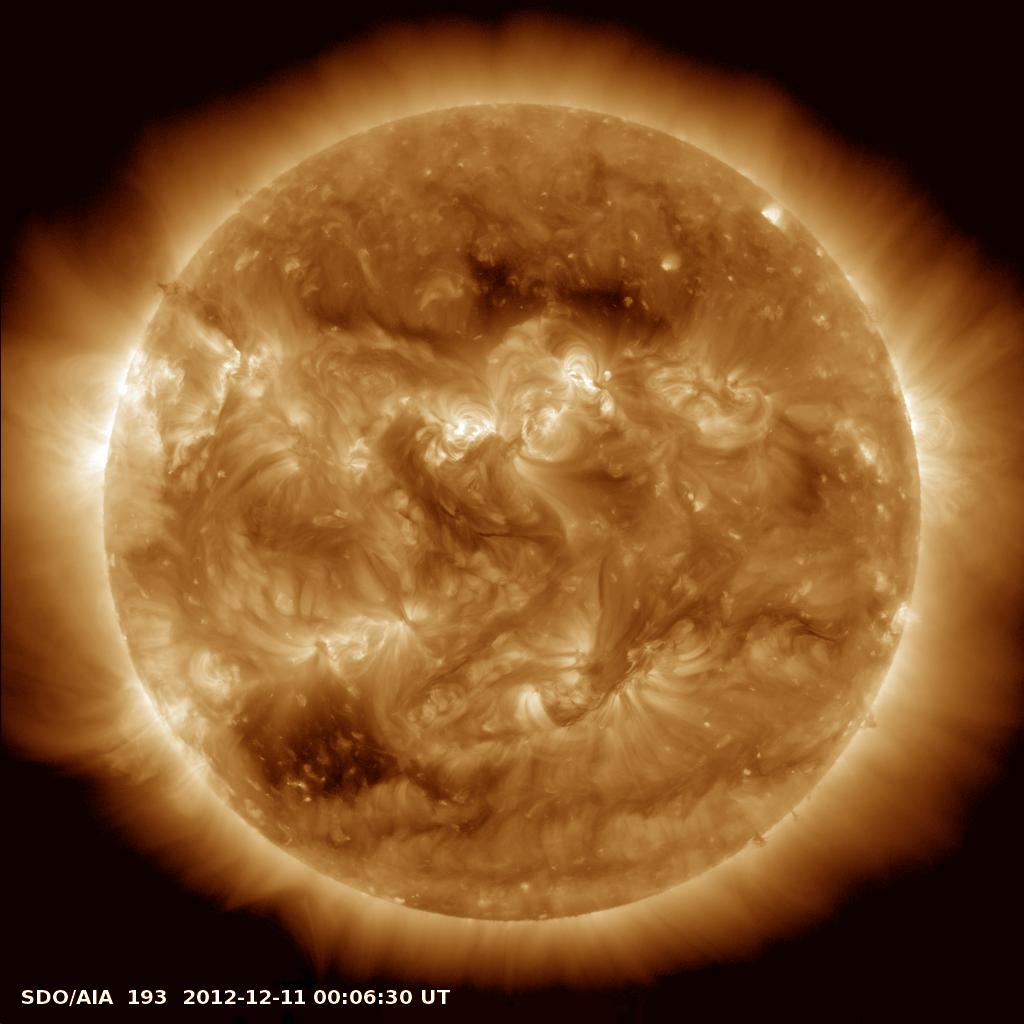

In [4]:
sample = df_train.iloc[0]

# 이미지 읽기
image_sample = Image.open(sample["image_path"])
image_sample

### 샘플 이미지의 라벨

라벨은 YOLO 형식으로 저장되어 있습니다.

YOLO 형식
`<object-class> <x> <y> <width> <height>`
- object-class: 물체의 클래스
- x, y: 바운딩 박스의 중심의 상대 좌표(0~1 사이 값)
- width, height: 바운딩 박스의 너비와 높이(0~1 사이 값)

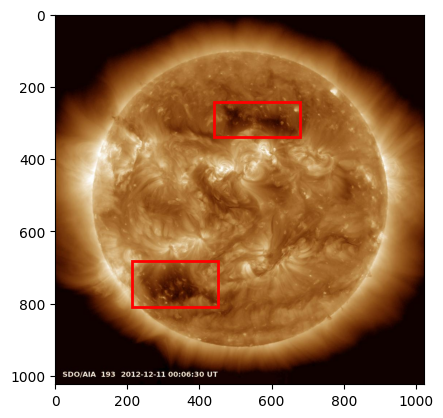

In [5]:
sample = df_train.iloc[0]
fig, ax = plt.subplots()

img = Image.open(sample["image_path"])

# 이미지 표시
ax.imshow(img)

# 박스 그리기
for label in sample["labels"]:
    # 좌표 변환
    c_x = label["x"] * img.width
    c_y = label["y"] * img.height
    w = label["w"] * img.width
    h = label["h"] * img.height

    left_top_x = c_x - w / 2
    left_top_y = c_y - h / 2

    rect = patches.Rectangle((left_top_x, left_top_y), w, h, linewidth=2, edgecolor="r", facecolor="none")
    ax.add_patch(rect)

fig.show()

## 데이터 전처리

### 데이터 분리

In [6]:
df_train_set = df_train.sample(frac=0.8, random_state=0)
df_valid_set = df_train.drop(df_train_set.index)

df_train_set.to_csv("train_set.csv", index=False)
df_valid_set.to_csv("valid_set.csv", index=False)

new_train_path = os.path.abspath("train")
new_valid_path = os.path.abspath("valid")

os.makedirs(new_train_path, exist_ok=True)
os.makedirs(os.path.join(new_train_path, IMAGE_DIR), exist_ok=True)
os.makedirs(os.path.join(new_train_path, LABELS_DIR), exist_ok=True)

os.makedirs(new_valid_path, exist_ok=True)
os.makedirs(os.path.join(new_valid_path, IMAGE_DIR), exist_ok=True)
os.makedirs(os.path.join(new_valid_path, LABELS_DIR), exist_ok=True)

### 데이터 전처리 및 복사

이미지의 크기를 변경하고 각각 폴더에 복사합니다.

YOLO 모델은 상대 좌표를 사용하므로 이미지의 크기가 변경되어도 상대 좌표는 그대로 사용할 수 있습니다.

사용하려는 모델이 절대 좌표를 사용한다면 이미지의 크기를 변경할 때 크기에 맞게 좌표를 변경해야 합니다.

In [7]:
IMAGE_SIZE = 256

for i, row in tqdm(df_train_set.iterrows(), total=len(df_train_set)):
    image = Image.open(row["image_path"])
    image.resize((IMAGE_SIZE, IMAGE_SIZE)).save(f"{new_train_path}/{IMAGE_DIR}/{row['id']}.jpg")
    shutil.copy(row["label_path"], f"{new_train_path}/{LABELS_DIR}/{row['id']}.txt")

for i, row in tqdm(df_valid_set.iterrows(), total=len(df_valid_set)):
    image = Image.open(row["image_path"])
    image.resize((IMAGE_SIZE, IMAGE_SIZE)).save(f"{new_valid_path}/{IMAGE_DIR}/{row['id']}.jpg")
    shutil.copy(row["label_path"], f"{new_valid_path}/{LABELS_DIR}/{row['id']}.txt")

100%|██████████| 2973/2973 [00:53<00:00, 55.39it/s]


## 모델 학습

### 모델 준비

외부 모델을 사용하는 경우 아래처럼 모델을 불러올 수 있습니다.

- 다운로드 하는 코드를 명시
- 필요한 종속성을 설치하는 코드를 명시

In [8]:
# YOLOv5 클론 및 설치 
!git clone https://github.com/ultralytics/yolov5.git 
!pip install --quiet -r yolov5/requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 16867, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 16867 (delta 14), reused 28 (delta 4), pack-reused 16825 (from 1)
Receiving objects: 100% (16867/16867), 15.60 MiB | 15.16 MiB/s, done.
Resolving deltas: 100% (11554/11554), done.

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


### 모델 학습

In [9]:
dataset = {
    "path": os.path.abspath("."),
    "train": "train",
    "val": "valid",
    "nc": 3,
    "names": ["coronal_hole", "sunspot", "prominence"],
}

YAML_PATH = os.path.abspath("sun.yaml")
RESULT_PATH = os.path.abspath("result")
os.makedirs(RESULT_PATH, exist_ok=True)
with open(YAML_PATH, "w") as f:
    yaml.dump(dataset, f)

In [10]:
!PYTHONWARNINGS="ignore::FutureWarning" python yolov5/train.py --img 256 --batch 128 --epoch 3 --data {YAML_PATH} --cfg yolov5s.yaml --exist-ok --weights yolov5s.pt --name sun --project {RESULT_PATH}

train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=/home/elicer/sun.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=3, batch_size=128, imgsz=256, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5/data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=/home/elicer/result, name=sun, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-353-g5eca7b9c Python-3.10.13 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100 80GB PCIe, 81051MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8

## 모델 평가

### 검증 데이터 예측

In [11]:
!python yolov5/detect.py --source {os.path.join(new_valid_path, IMAGE_DIR)} --weights {RESULT_PATH}/sun/weights/best.pt --conf 0.5 --save-txt --save-conf --exist-ok --project {RESULT_PATH}/valid

detect: weights=['/home/elicer/result/sun/weights/best.pt'], source=/home/elicer/valid/images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/home/elicer/result/valid, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-353-g5eca7b9c Python-3.10.13 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100 80GB PCIe, 81051MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/2973 /home/elicer/valid/images/000874f15ca147d68b71c5a1a4478a08.jpg: 640x640 (no detections), 5.0ms
image 2/2973 /home/elicer/valid/images/000a149a18b74a55a0c914258c369abc.jpg: 640x640 5 sunspots, 5.0ms
image 3/2973 /home/elicer/valid/images/002cdcade83b4b92ab541c34c87ba90d

### 예측 결과 시각화

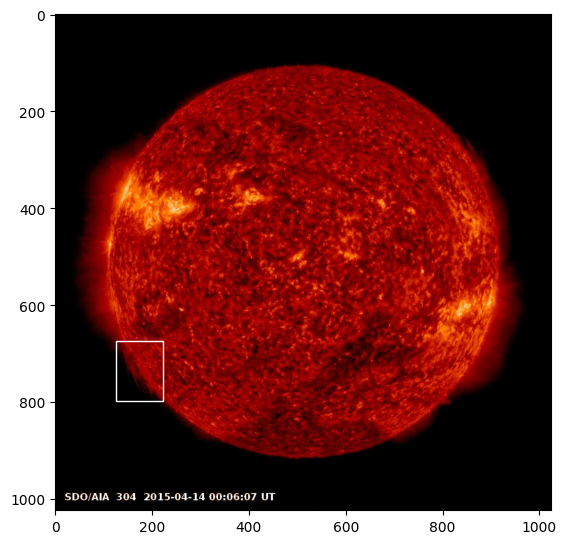

In [12]:
sample = df_valid_set.iloc[3]
fig, ax = plt.subplots()

img = Image.open(sample["image_path"])
ax.imshow(img)

# 예측 결과 시각화
predict = os.path.join(RESULT_PATH, "valid", "exp", "labels", sample["id"] + ".txt")
if os.path.exists(predict):
    with open(predict, "r") as f:
        for line in f.readlines():
            class_id, c_x, c_y, w, h, conf = map(float, line.split())
            c_x *= img.width
            c_y *= img.height
            w *= img.width
            h *= img.height

            left_top_x = c_x - w / 2
            left_top_y = c_y - h / 2

            rect = patches.Rectangle(
                (left_top_x, left_top_y), w, h, linewidth=1, edgecolor="r", facecolor="none"
            )
            ax.add_patch(rect)

# 정답 시각화
with open(sample["label_path"], "r") as f:
    for line in f.readlines():
        class_id, c_x, c_y, w, h = map(float, line.split())
        c_x *= img.width
        c_y *= img.height
        w *= img.width
        h *= img.height

        left_top_x = c_x - w / 2
        left_top_y = c_y - h / 2

        rect = patches.Rectangle((left_top_x, left_top_y), w, h, linewidth=1, edgecolor="w", facecolor="none")
        ax.add_patch(rect)
fig.set_figheight(10)
fig.show()

## 제출 파일 생성

### 테스트 데이터 예측

In [13]:
!python yolov5/detect.py --source {os.path.join(DATASET_ROOT, TEST_DIR, IMAGE_DIR)} --weights {RESULT_PATH}/sun/weights/best.pt --conf 0.5 --save-txt --save-conf --exist-ok --project {RESULT_PATH}/test

detect: weights=['/home/elicer/result/sun/weights/best.pt'], source=/mnt/elice/dataset/test/images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/home/elicer/result/test, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-353-g5eca7b9c Python-3.10.13 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100 80GB PCIe, 81051MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/6369 /mnt/elice/dataset/test/images/001f5cc5f47541518b712d6b0a6d18cc.jpg: 640x640 8 sunspots, 5.5ms
image 2/6369 /mnt/elice/dataset/test/images/002138bcbd4343b6a6739c6f21f163d8.jpg: 640x640 1 coronal_hole, 5.5ms
image 3/6369 /mnt/elice/dataset/test/images/002bc502b8254f

### 바운드 박스 읽어오기

In [14]:
for i, row in tqdm(df_test.iterrows(), total=len(df_test)):
    label_path = os.path.join(RESULT_PATH, "test", "exp", "labels", row["id"] + ".txt")

    labels = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            class_id, c_x, c_y, w, h, conf = map(float, line.split())
            labels.append({"class_id": int(class_id), "conf": conf, "x": c_x, "y": c_y, "w": w, "h": h})

    df_test.at[i, "labels"] = labels
df_test

100%|██████████| 6369/6369 [00:00<00:00, 7436.83it/s]


,id,image_path,label_path,labels
0,8abb1e02042142928d5280eb2137d538,/mnt/elice/dataset/test/images/8abb1e020421429...,,"[{'class_id': 1, 'conf': 0.538682, 'x': 0.9272..."
1,e2019257735b4230b8669e8372b9b339,/mnt/elice/dataset/test/images/e2019257735b423...,,[]
2,2e31937421354646854d599dccc2c80e,/mnt/elice/dataset/test/images/2e3193742135464...,,[]
3,29da3a3a93ec4c71b5415cfaac520831,/mnt/elice/dataset/test/images/29da3a3a93ec4c7...,,"[{'class_id': 1, 'conf': 0.53726, 'x': 0.71435..."
4,4d02b3570c414445b34516800e5eef75,/mnt/elice/dataset/test/images/4d02b3570c41444...,,"[{'class_id': 0, 'conf': 0.550988, 'x': 0.5170..."
...,...,...,...,...
6364,7a78ae524a5046889713af57538adbee,/mnt/elice/dataset/test/images/7a78ae524a50468...,,[]
6365,c45fea81e7db468496d57044fa4f3e5a,/mnt/elice/dataset/test/images/c45fea81e7db468...,,[]
6366,2715986383dc466ca338bd7167ce1fd6,/mnt/elice/dataset/test/images/2715986383dc466...,,"[{'class_id': 1, 'conf': 0.548831, 'x': 0.8618..."
6367,e94fad68d94348168d8cf3482e49f7b3,/mnt/elice/dataset/test/images/e94fad68d943481...,,"[{'class_id': 0, 'conf': 0.505493, 'x': 0.3793..."


### 생성되는 CSV 파일의 형식

CSV 파일은 각 이미지에 대한 정보를 포함하며, 다음과 같은 열(column)로 구성됩니다: 

| id        | labels                             | 
|-----------|------------------------------------| 
| image_id  | [{"class_id": ..., "x": ..., "y": ..., "w": ..., "h": ...}, ...] | 

각 행(row)은 다음과 같은 내용을 포함합니다: 
- id: 이미지의 고유 식별자 (image_id) 
- labels: 해당 이미지에 대한 라벨 정보를 포함하는 리스트 
  - 각 라벨은 다음과 같은 정보를 포함합니다: 
    - class_id: 객체의 클래스 ID 
    - x: 객체의 x 좌표 (YOLO 형식) 
    - y: 객체의 y 좌표 (YOLO 형식) 
    - w: 객체의 너비 (YOLO 형식) 
    - h: 객체의 높이 (YOLO 형식) 

예시: 
| id         | labels                                                       | 
|------------|--------------------------------------------------------------| 
| image_001  | [{"class_id": 1, "x": 0.5, "y": 0.5, "w": 0.2, "h": 0.3}] | 
| image_002  | [{"class_id": 2, "x": 0.3, "y": 0.4, "w": 0.1, "h": 0.2}, {"class_id": 1, "x": 0.7, "y": 0.8, "w": 0.15, "h": 0.25}] | 

주의: YOLO 형식의 x, y, w, h는 각각 이미지의 너비와 높이에 대한 비율로 표현되며, 
      x와 y는 객체의 중심 좌표를 기준으로 하고, w와 h는 객체의 크기를 나타냅니다.

### 제출 파일 생성

In [15]:
submission = []

for i, row in tqdm(df_test.iterrows(), total=len(df_test)):
    image_id = row["id"]
    labels = []
    for label in row["labels"]:
        class_id = label["class_id"]
        x = label["x"]
        y = label["y"]
        w = label["w"]
        h = label["h"]

        labels.append({"class_id": class_id, "x": x, "y": y, "w": w, "h": h})
    submission.append({"id": image_id, "labels": labels})

df_submission = pd.DataFrame(submission)
df_submission.to_csv("submission.csv", index=False)

100%|██████████| 6369/6369 [00:00<00:00, 14564.47it/s]


### 제출 파일 확인

제출한 파일이 올바른 형식인지 확인합니다.

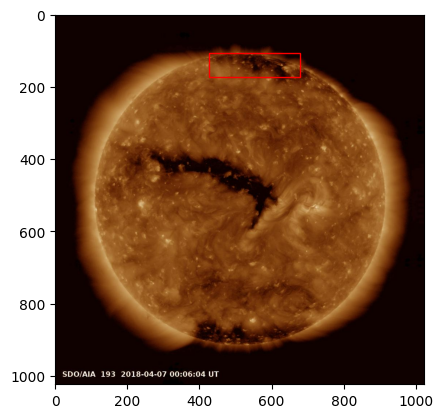

In [16]:
df_submission = pd.read_csv("submission.csv")

sample = df_submission.iloc[9]
sample_labels = eval(sample["labels"])

if len(sample_labels) == 0:
    print("예측결과: 해당 이미지에선 발견된 이벤트가 없습니다.")
else:
    fig, ax = plt.subplots()
    img = Image.open(os.path.join(DATASET_ROOT, TEST_DIR, IMAGE_DIR, sample["id"] + ".jpg"))
    ax.imshow(img)

    # 예측 결과 시각화
    for label in sample_labels:
        class_id = label["class_id"]
        cx = label["x"] * img.width
        cy = label["y"] * img.height
        w = label["w"] * img.width
        h = label["h"] * img.height

        left_top_x = cx - (w / 2)
        left_top_y = cy - h / 2

        rect = patches.Rectangle((left_top_x, left_top_y), w, h, linewidth=1, edgecolor="r", facecolor="none")
        ax.add_patch(rect)

## 제출

오른쪽 위의 '제출' 버튼을 클릭하여 제출합니다.